#  XPCS   SAXS Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [591]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [256]:
#hdr = db[{{ uid }}]

In [592]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [593]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages
#register the fancy lazy chx eiger handler
from chxtools import handlers

### Lazy Eiger Handler (later will goto databroker)

In [594]:
%matplotlib notebook
#%matplotlib inline

### Get the events from the uid

In [595]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("%s: %s" % (key, val))

In [596]:


uid = '1d23b29d-d9bb-49e4-a147'


hdr = db[uid]


In [597]:
print ( hdr )


header
  
  EventDescriptor
  ---------------
  configuration   :
  +---------------+-------+------------+-------------+-----------------+---------------------------+
  | data keys     | dtype |  external  | object_name |      shape      |           source          |
  +---------------+-------+------------+-------------+-----------------+---------------------------+
  | eiger4m_image | array | FILESTORE: |   eiger4m   | [2070, 2167, 0] | PV:XF:11IDB-ES{Det:Eig4M} |
  +---------------+-------+------------+-------------+-----------------+---------------------------+
  run_start       : 1d23b29d-d9bb-49e4-a147-f596e2742c40    
  time            : 1454781659.6570973                      
  uid             : 64ebceea-72a2-415a-a244-32bc14ff5dbc    
  
  RunStart
  --------
  beamline_id     : CHX                                     
  config          :
  detectors       : ['eiger4m']                             
  group           : chx                                     
  owner          

In [598]:
ev, = get_events(hdr, ['eiger4m_image'])

hdf5 path = /XF11ID/data/2016/02/04/d83f9901-47ed-4f95-b06d_423_master.h5


In [599]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2016/2/6/'

In [600]:
#imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
imgs = ev['data']['eiger4m_image']

print (imgs)
Nimg=len(imgs)

<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


In [452]:
#Nimg

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [601]:
imgs.md

{'beam_center_x': 852.0,
 'beam_center_y': 1830.0,
 'count_time': 0.00133,
 'detector_distance': 4.8400002,
 'frame_time': 0.00134,
 'incident_wavelength': 1.3776,
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [602]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4840        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(0.00134, 0.00133)

## load a mask if exist 
### otherwise create a mask using Mask pipeline

In [603]:
#mask = np.load(uid+"_mask.npy")
#mask = np.load( path +  str(uid)+"_mask.npy")

mask = np.load( '/XF11ID/analysis/2016/2/' +  '_sandro'+"_mask_05.npy" )

## Plot the mask

In [604]:
%matplotlib notebook

<IPython.core.display.Javascript object>


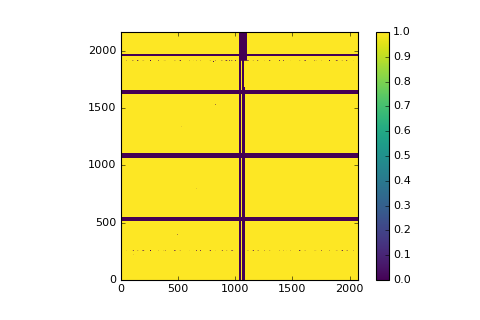

In [605]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

### hey, let's see if any images are bad!

In [606]:
bin_img = 50
imgsum = [np.sum(img *mask) for img in imgs[::bin_img]]

<IPython.core.display.Javascript object>


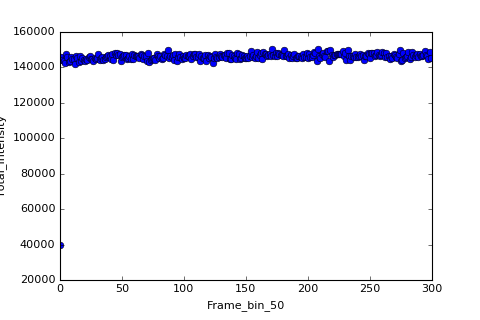

In [607]:
fig, ax = plt.subplots()  
ax.plot(imgsum,'bo')
ax.set_xlabel( 'Frame_bin_%s'%bin_img )
ax.set_ylabel( 'Total_Intensity' )
plt.show()

### Get the Averaged Image Data

In [608]:
avg_img = np.average(imgs[::100], axis=0)*mask

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


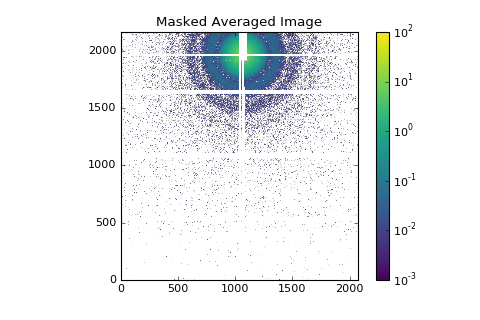

In [609]:
img_mask = avg_img * mask

fig, ax = plt.subplots()
im = ax.imshow(img_mask, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e2))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Import all the required packages for  Data Analysis

* scikit-beam - data analysis tools for X-ray science 
    - https://github.com/scikit-beam/scikit-beam
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision


In [610]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

import skbeam.core.roi as roi

import skbeam.core.correlation as corr
import skbeam.core.utils as utils

## Get the approximate center and see the statistic to make sure 

In [611]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(852.0, 1830.0)

In [612]:

center = [1060, 1958]  # center of the speckle pattern

center = [1061, 1960]  # center of the speckle pattern

#center = [860, 958]  # center of the speckle pattern
center=[center[1], center[0]]

center

[1960, 1061]

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [613]:
bin_centers, ring_averages= roi.circular_average(img_mask, 
        center, threshold=0, nx=1500, pixel_size=(dpix, dpix))

#  convert to q (reciprocal space)
two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
q_val = utils.twotheta_to_q(two_theta, lambda_)

In [495]:
#from chxtools import develop as dev

In [496]:
#cd /XF11ID/analysis/Analysis_Pipelines/Develop/
#%run develop.py
#bin_centers, ring_averages= circular_average(avg_img,  center, 
#                                        pixel_size=(dpix, dpix), mask= mask)

#  convert to q (reciprocal space)
#two_theta = utils.radius_to_twotheta(Ldet, bin_centers)
#q_val = utils.twotheta_to_q(two_theta, lambda_)

<IPython.core.display.Javascript object>


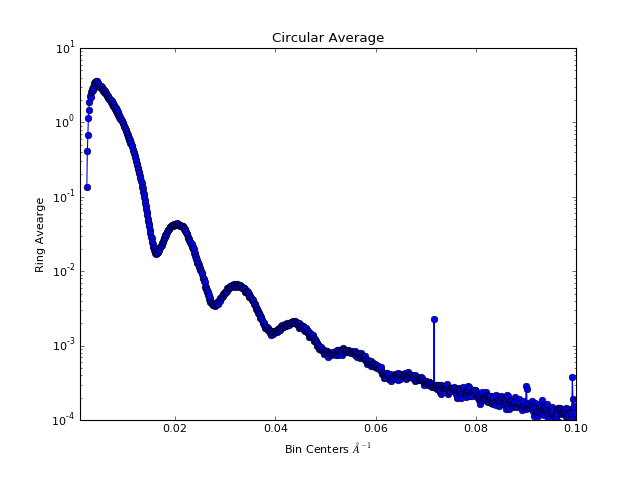

In [614]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(q_val, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
axes.set_xlim(0.001, 0.1)
axes.set_ylim(0.0001, 10)
plt.show()

<IPython.core.display.Javascript object>


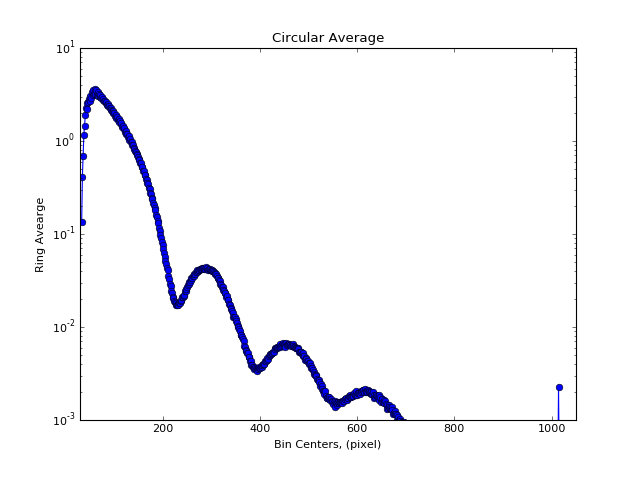

In [615]:
fig,axes = plt.subplots(figsize=(8, 6))
axes.semilogy(bin_centers/dpix, ring_averages, '-o')
axes.set_title('Circular Average')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers, (pixel)')
axes.set_xlim(30,  1050)
axes.set_ylim(0.001, 10.0)
plt.show()

## Create label array (Q rings)

In [616]:
inner_radius = 44  # radius of the first ring

inner_radius = 64  # radius of the first ring
width = 2       # width of each ring
spacing =  (119 - 44)/9 - 2    # spacing between rings

#spacing =  (459 - 44)/9 - 2    # spacing between rings

num_rings = 12   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  64.        ,   66.        ],
       [  72.33333333,   74.33333333],
       [  80.66666667,   82.66666667],
       [  89.        ,   91.        ],
       [  97.33333333,   99.33333333],
       [ 105.66666667,  107.66666667],
       [ 114.        ,  116.        ],
       [ 122.33333333,  124.33333333],
       [ 130.66666667,  132.66666667],
       [ 139.        ,  141.        ],
       [ 147.33333333,  149.33333333],
       [ 155.66666667,  157.66666667]])

In [617]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00459395,  0.00518291,  0.00577188,  0.00636085,  0.00694981,
        0.00753878,  0.00812774,  0.00871671,  0.00930567,  0.00989464,
        0.0104836 ,  0.01107257])

In [618]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask

## Extract the labeled array

In [502]:
#ring_mask

In [619]:
labels, indices = roi.extract_label_indices(ring_mask)

In [504]:
#labels

In [505]:
#indices

## Number of pixels in each q ring

In [620]:
nopr = np.bincount( np.array(labels, dtype=int) )[1:]
nopr

array([ 534,  667,  716,  873,  965, 1059, 1183, 1263, 1382, 1486, 1568,
       1665])

# check center

<IPython.core.display.Javascript object>


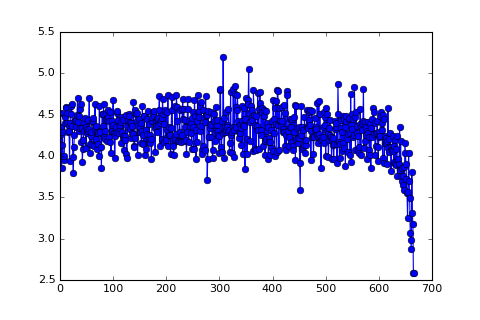

In [621]:
pixel = roi.roi_pixel_values(avg_img*mask, ring_mask, [2] )
fig, ax = plt.subplots()
ax.plot( pixel[0][0] ,'bo', ls='-' )
plt.show()

<IPython.core.display.Javascript object>


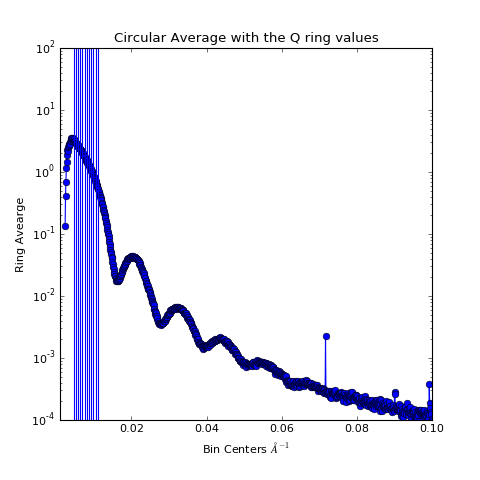

In [622]:
fig, axes = plt.subplots( figsize=(6, 6))
axes.semilogy(q_val, ring_averages, '-o')
#axes.plot(q_val, ring_averages, '-o')
axes.set_title('Circular Average with the Q ring values')
axes.set_ylabel('Ring Avearge')
axes.set_xlabel('Bin Centers 'r'$\AA^{-1}$')
#axes.set_xlim(0, 0.02)
axes.set_xlim(0.001, 0.1)
axes.set_ylim(0.0001, 100)
#axes.set_ylim(0, 100)
for i in range(num_rings):
    axes.axvline(q_ring_center[i])
plt.show()

## To mask the each image

In [623]:
class Masker(object):
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask

In [624]:
masker = Masker(imgs, mask)

<IPython.core.display.Javascript object>


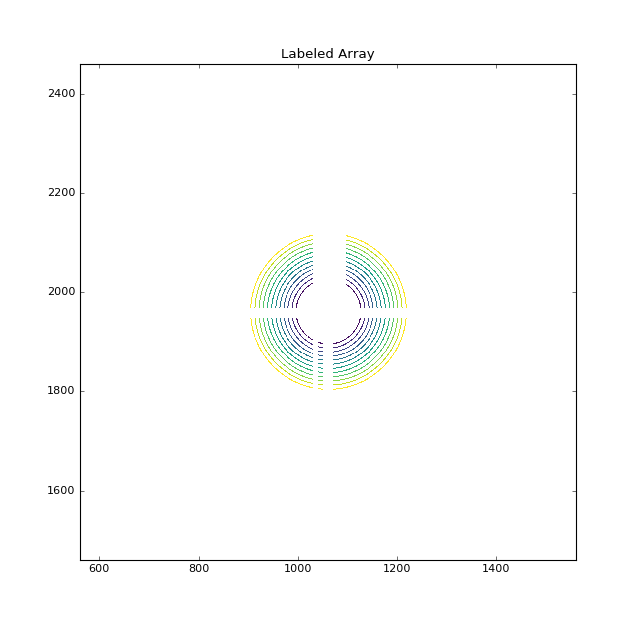

(1460, 2460)

In [625]:
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
im = mpl_plot.show_label_array(axes, ring_mask, cmap='viridis',origin='lower')

rwidth = 500 

x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])


##  Kymograph(waterfall plot) of a ring

In [512]:
#kymo = roi.kymograph(masker[::50], ring_mask, num = 4)  # eg: num=4 , 4th ring

In [513]:
#fig, ax = plt.subplots(figsize=(6,8))
#ax.set_ylabel('Pixel')
#ax.set_xlabel('Frame')
#ax.set_title('Kymograph')

#im = ax.imshow(kymo.T, cmap='viridis', vmax=100)
#fig.colorbar( im   )
#ax.set_aspect(0.05)
#plt.show()

##  Mean intensities for each ring

In [626]:
mask_data = masker[::300]  #this one is too slow if make  masker[::1]
mean_int_sets, index_list = roi.mean_intensity(mask_data, ring_mask)

In [627]:
%matplotlib notebook

<IPython.core.display.Javascript object>


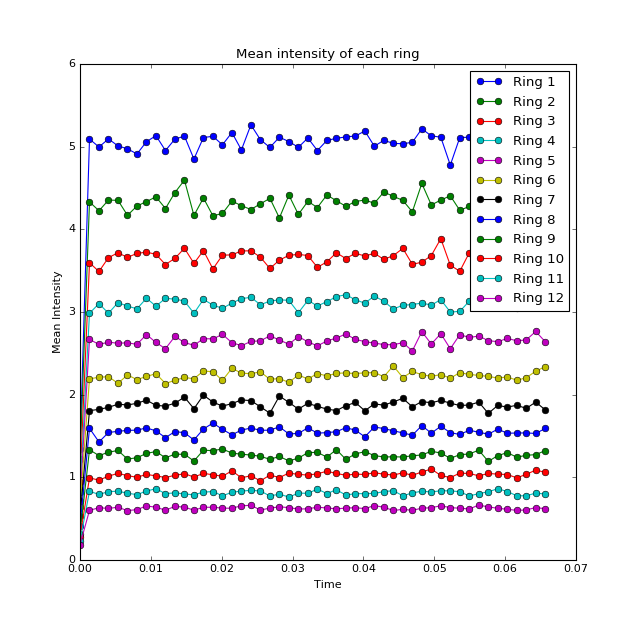

In [628]:
time = np.arange(len(mask_data))*timeperframe  # get the time for each frame


fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1),marker = 'o', ls='-')
    ax.set_xlabel("Time")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

In [629]:
ring_mask = np.array(ring_mask, dtype=int)

In [630]:
imgs

<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

In [631]:
imgs_ = imgs[10:15000]

In [580]:
noframes = len( imgs_)
print (noframes)

14990


In [632]:
#num_lev = 12  # number of levels
num_buf = 8  # number of buffers
num_lev = int(np.log( noframes/(num_buf-1))/np.log(2) +1) +1

g2, lag_steps = corr.multi_tau_auto_corr(num_lev, num_buf,   ring_mask, imgs_)

In [633]:
num_lev

13

In [523]:
#corr.lazy_one_time??

In [634]:
%matplotlib inline

### Plot the one time correlation functions

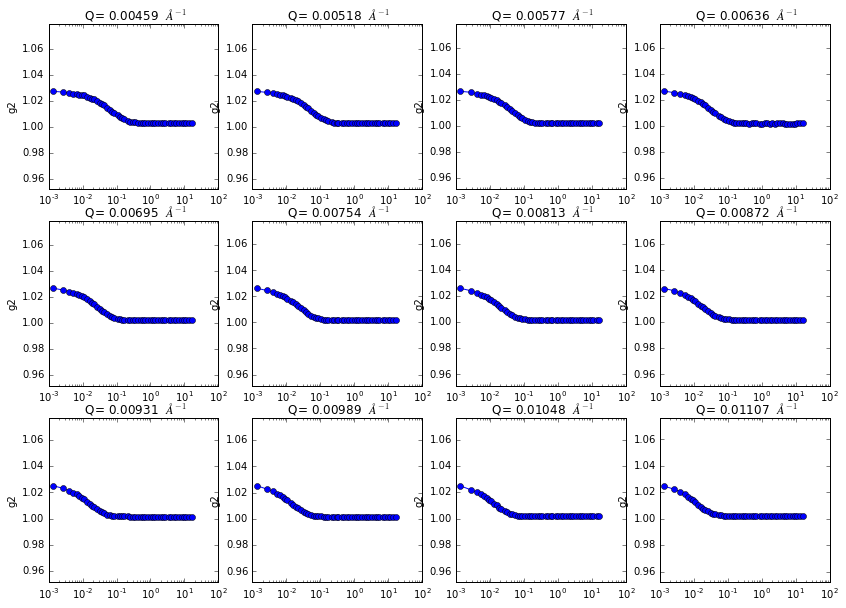

In [635]:
lags = lag_steps*timeperframe

sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    y=g2[:, i]
    ax.semilogx(lags, y, '-o', markersize=6) 
    ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
plt.show()
fig.tight_layout()  

# Fit g2

In [636]:
%matplotlib inline

In [641]:
def stretched_auto_corr_scat_factor(lags, beta, relaxation_rate, alpha, baseline=1):
    return beta * (np.exp(-2 * relaxation_rate * lags))**alpha + baseline

In [638]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)
mods = Model(stretched_auto_corr_scat_factor)

## using a simple exponential model to fit data

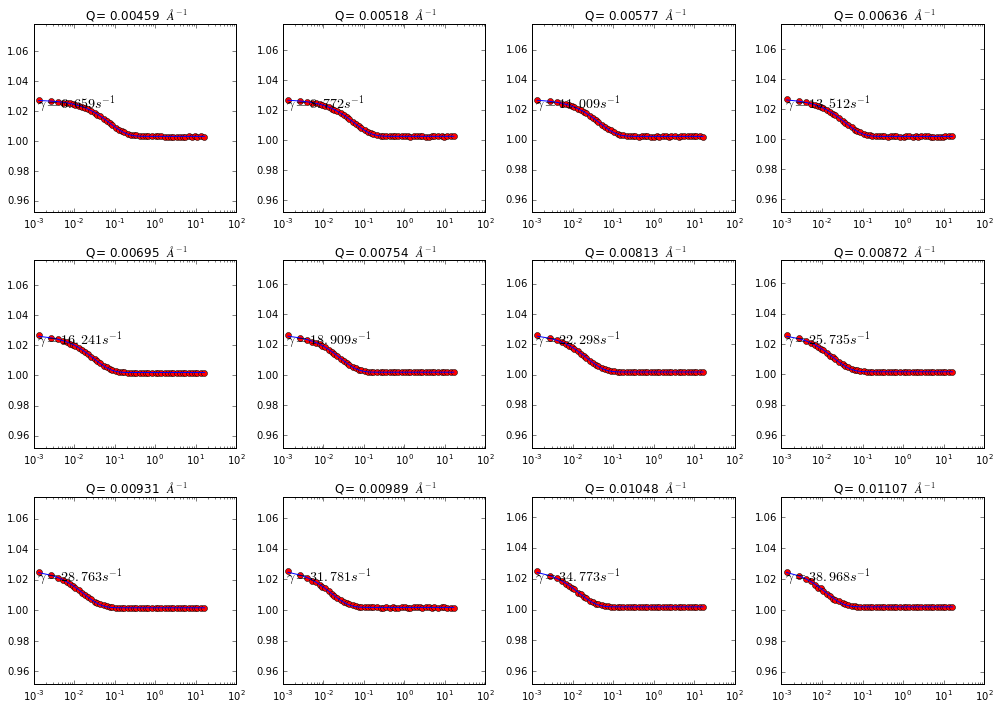

In [639]:
rate = []  #  relaxation rate

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid, fontsize=20, y =1.02) 
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    y=g2[1:, i]
    result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
    rate.append(result1.best_values['relaxation_rate'])
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rate[i]) +  r'$ s^{-1}$'
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes)              
fig.tight_layout()  
plt.show()

## using a streched exponential model to fit data

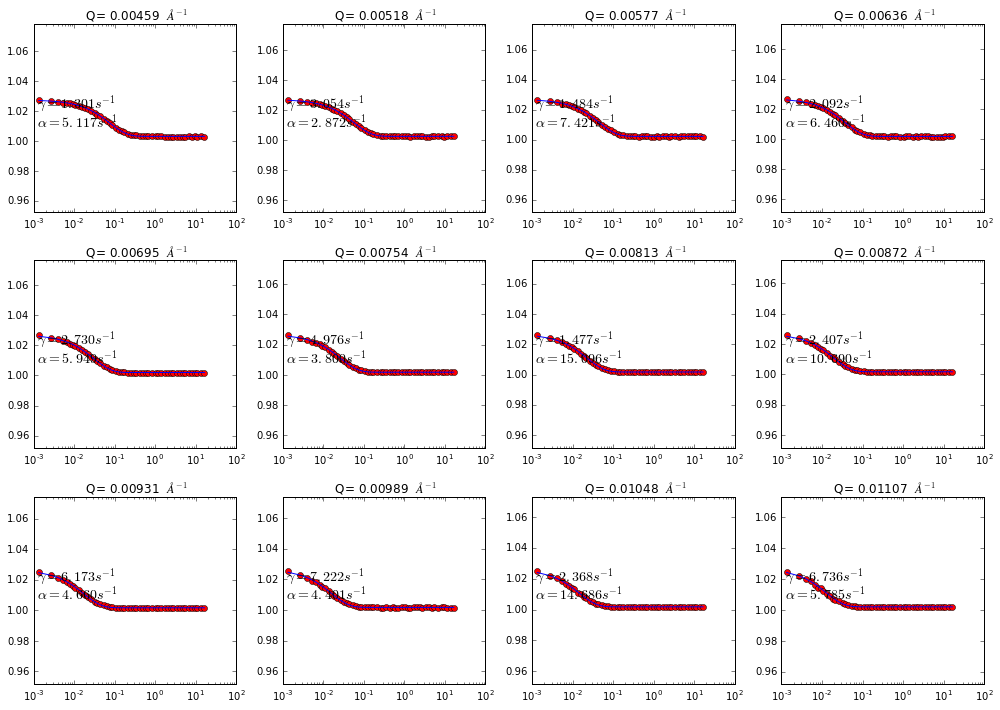

In [642]:
rates = []  #  relaxation rate
alphas = []  #  relaxation rate

sx = int( round (np.sqrt(num_rings)) )
if num_rings%sx==0:
    sy = int(num_rings/sx)
else:
    sy = int(num_rings/sx+1)
    
fig = plt.figure(figsize=(14, 10))
plt.title('uid= %s'%uid, fontsize=20, y =1.02) 
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    y=g2[1:, i]
    result1 = mods.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, alpha=1., baseline=1.0)
    rates.append(result1.best_values['relaxation_rate'])
    alphas.append( result1.best_values['alpha'] )
    
    ax.semilogx(lags[1:], y, 'ro')
    ax.semilogx(lags[1:], result1.best_fit, '-b')
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')  
    ax.set_ylim([min(y)*.95, max(y[1:]) *1.05])
    txts = r'$\gamma$' + r'$ = %.3f$'%(rates[i]) +  r'$ s^{-1}$'    
    ax.text(x =0.015, y=.55, s=txts, fontsize=14, transform=ax.transAxes) 
    
    txts = r'$\alpha$' + r'$ = %.3f$'%(alphas[i]) +  r'$ s^{-1}$'    
    ax.text(x =0.015, y=.45, s=txts, fontsize=14, transform=ax.transAxes) 
    
fig.tight_layout()  
plt.show()

In [531]:
rate

[24.307629113676711,
 31.27706476737918,
 39.322034673394022,
 48.652525743410997,
 57.748473230614188,
 68.080486463342169,
 76.15411539421595,
 88.737722433849981,
 98.620505469916978,
 124.5217945339536,
 127.69615483251535,
 151.67619032223107]

In [532]:
result1.best_values

{'alpha': 10.737442014709966,
 'baseline': 1.0016340706784734,
 'beta': 0.030508475146250234,
 'relaxation_rate': 14.125837266341957}

## Plot the relaxation rates vs (q_ring_center)**2

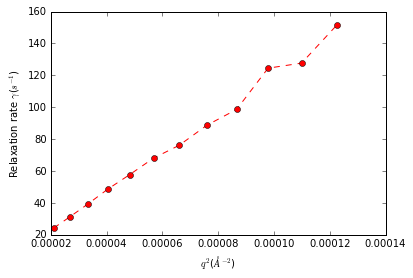

In [533]:
fig, ax = plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

# Fitted the Diffusion Coefficinet D0

In [534]:
r'($\AA^{-2}$)'

'($\\AA^{-2}$)'

In [535]:
D0 = np.polyfit(q_ring_center**2, rate, 1)
gmfit = np.poly1d(D0)
'The fitted diffusion coefficient D0 is:  %.2E'r'($\AA^{-2}$)'%D0[0]

'The fitted diffusion coefficient D0 is:  1.22E+06($\\AA^{-2}$)'

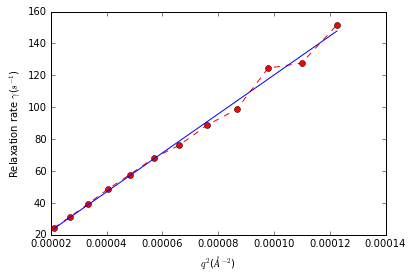

In [536]:
fig, ax = plt.subplots()
ax.plot(q_ring_center**2, rate, 'ro', ls='--')
ax.plot(q_ring_center**2,  gmfit(q_ring_center**2),  ls='-')
ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

## Removing bad images 

In [ ]:
import skbeam.core.mask as mask

bad_img_list = [2, 30, 206, 300, 405]

new_imgs = mask.bad_to_nan_gen(imgs, bad_img_list)

In [ ]:
g2_n, lag_steps_n = corr.multi_tau_auto_corr(num_lev, num_buf,
                                         ring_mask, new_imgs)

In [ ]:
lags_n = lag_steps_n*timeperframe

sx = int(round(np.sqrt(num_rings)) )
if num_rings%sx == 0: 
    sy = int(num_rings/sx)
else:
    sy=int(num_rings/sx+1)
fig = plt.figure(figsize=(16, 12))
plt.title('uid= %s'%uid,fontsize=20, y =1.02)
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])
for i in range(num_rings):
    ax = fig.add_subplot(sx, sy, i+1 )
    ax.set_ylabel("g2") 
    ax.set_title(" Q= " + '%.5f  '%(q_ring_center[i]) + r'$\AA^{-1}$')
    y_n = g2_n[:, i]
    ax.semilogx(lags_n, y_n, '-o', markersize=6) 
    ax.set_ylim([min(y_n)*.95, max(y_n[1:])*1.05 ])
plt.show()
fig.tight_layout()  

In [ ]:
np.sqrt(0.06)